# verifique o próximo arquivo que mostra comparações.

In [8]:
# Importando as bibliotecas necessárias
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# Carrega e prepara o dataset MNIST
def carregar_e_preparar_dados():
    # Carrega o dataset MNIST e normaliza os valores dos pixels
    (x_treino, y_treino), (x_teste, y_teste) = tf.keras.datasets.mnist.load_data()
    x_treino, x_teste = x_treino / 255.0, x_teste / 255.0
    y_treino = tf.keras.utils.to_categorical(y_treino, 10)
    y_teste = tf.keras.utils.to_categorical(y_teste, 10)
    return (x_treino, y_treino), (x_teste, y_teste)

(x_treino, y_treino), (x_teste, y_teste) = carregar_e_preparar_dados()

In [10]:
# Plotar a acurácia e a perda
def plotar_historico(historico, titulo):
    # Plota a acurácia de treinamento e validação ao longo das épocas
    plt.plot(historico.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title(titulo)
    plt.legend()
    plt.show()

    # Plota a perda de treinamento e validação ao longo das épocas
    plt.plot(historico.history['loss'], label='Perda de Treinamento')
    plt.plot(historico.history['val_loss'], label='Perda de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.title(titulo)
    plt.legend()
    plt.show()
    

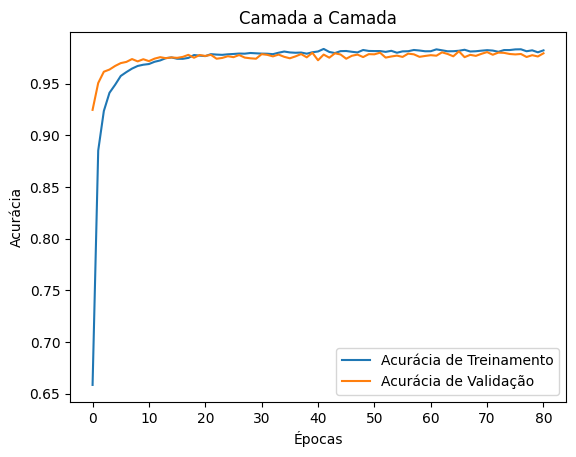

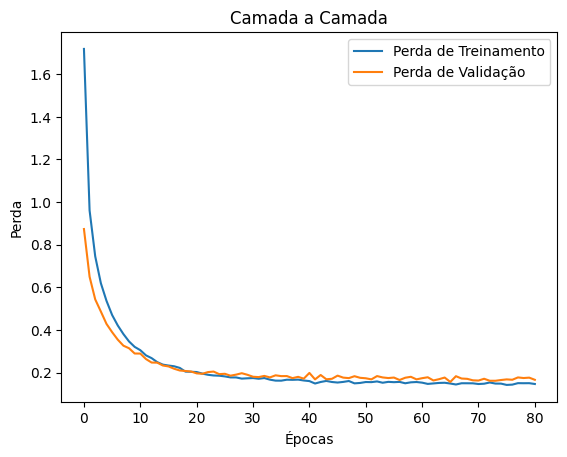

Camada a Camada - Perda: 0.14580455422401428, Acurácia: 0.9825999736785889, Épocas: 81


In [11]:
def treinar_camada_a_camada(x_treino, y_treino, x_teste, y_teste):
    modelo = Sequential()
    modelo.add(Flatten(input_shape=(28, 28)))
    
    # Adicionando 5 camadas intermediárias com Dropout e Batch Normalization
    unidades_por_camada = [256, 128, 64, 32, 16]
    for unidades in unidades_por_camada:
        modelo.add(Dense(unidades, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        modelo.add(BatchNormalization())
        modelo.add(Dropout(0.2))

    # Adicionando a camada de saída
    modelo.add(Dense(10, activation='softmax'))
    
    # Compilando o modelo com Adam e função de perda de entropia cruzada categórica
    modelo.compile(optimizer=Adam(learning_rate=0.0005), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    
    # Treinando o modelo com Early Stopping para evitar overfitting
    parada_precoce = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    historico = modelo.fit(x_treino, y_treino, epochs=1000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[parada_precoce])
    
    # Avaliando o modelo no conjunto de teste
    perda_teste, acuracia_teste = modelo.evaluate(x_teste, y_teste, verbose=0)
    plotar_historico(historico, "Camada a Camada")
    return modelo, perda_teste, acuracia_teste, len(historico.history['loss'])

modelo_camada_a_camada, perda_camada_a_camada, acuracia_camada_a_camada, epocas_camada_a_camada = treinar_camada_a_camada(x_treino, y_treino, x_teste, y_teste)
print(f'Camada a Camada - Perda: {perda_camada_a_camada}, Acurácia: {acuracia_camada_a_camada}, Épocas: {epocas_camada_a_camada}')


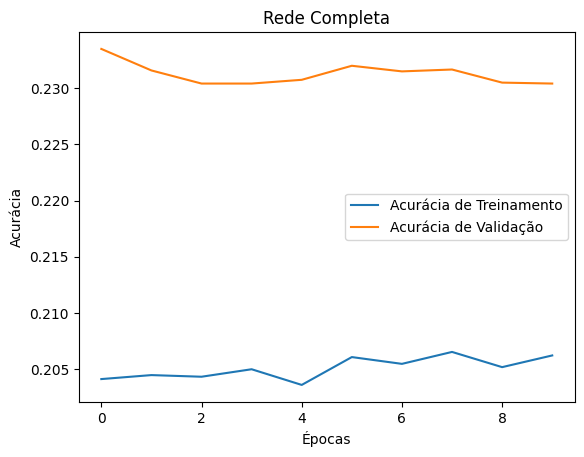

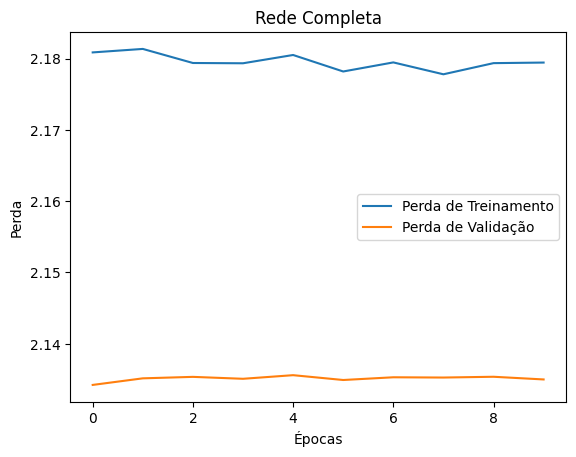

Rede Completa - Perda: 2.127824306488037, Acurácia: 0.24770000576972961, Épocas: 139


In [12]:
# Treinando a rede completa com congelamento/descongelamento de camadas
def treinar_rede_completa(x_treino, y_treino, x_teste, y_teste):
    modelo = Sequential()
    modelo.add(Flatten(input_shape=(28, 28)))
    
    # Adicionando 5 camadas intermediárias com Dropout e Batch Normalization
    unidades_por_camada = [256, 128, 64, 32, 16]
    for unidades in unidades_por_camada:
        modelo.add(Dense(unidades, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        modelo.add(BatchNormalization())
        modelo.add(Dropout(0.2))
    
    # Adicionando a camada de saída
    modelo.add(Dense(10, activation='softmax'))
    
    # Congelar todas as camadas exceto a última durante o treinamento inicial
    for camada in modelo.layers[:-1]:
        camada.trainable = False

    # Compilando o modelo
    modelo.compile(optimizer=Adam(learning_rate=0.0005), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    parada_precoce = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    historico = modelo.fit(x_treino, y_treino, epochs=1000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[parada_precoce])
    
    # Descongelar todas as camadas e treinar novamente
    for camada in modelo.layers:
        camada.trainable = True
    historico_final = modelo.fit(x_treino, y_treino, epochs=1000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[parada_precoce])
    
    # Avaliando o modelo no conjunto de teste
    perda_teste, acuracia_teste = modelo.evaluate(x_teste, y_teste, verbose=0)
    plotar_historico(historico_final, "Rede Completa")
    return modelo, perda_teste, acuracia_teste, len(historico.history['loss']) + len(historico_final.history['loss'])

modelo_rede_completa, perda_rede_completa, acuracia_rede_completa, epocas_rede_completa = treinar_rede_completa(x_treino, y_treino, x_teste, y_teste)
print(f'Rede Completa - Perda: {perda_rede_completa}, Acurácia: {acuracia_rede_completa}, Épocas: {epocas_rede_completa}')


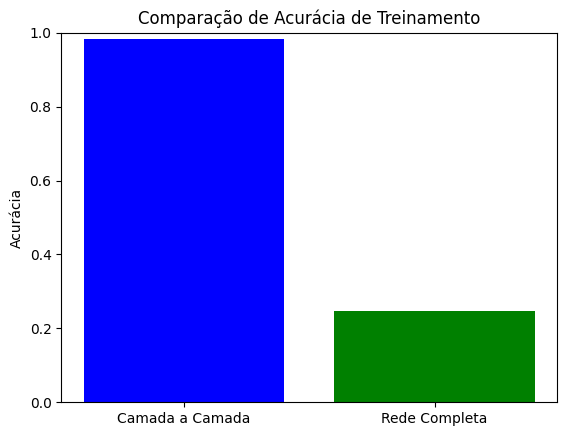

In [14]:
# Visualização dos Resultados
def plotar_resultados_treinamento(acuracia_camada_a_camada, acuracia_rede_completa):
    etiquetas = ['Camada a Camada', 'Rede Completa']
    acuracias = [acuracia_camada_a_camada, acuracia_rede_completa]
    plt.bar(etiquetas, acuracias, color=['blue', 'green', 'yellow'])
    plt.ylabel('Acurácia')
    plt.title('Comparação de Acurácia de Treinamento')
    plt.ylim(0, 1)
    plt.show()

# Chamada da função com as três acurácias
plotar_resultados_treinamento(acuracia_camada_a_camada, acuracia_rede_completa)